In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load the benchmark results
with open('benchmarking/benchmark_results.json', 'r') as f:
    results = json.load(f)

df = pd.DataFrame(results)

/var/folders/yz/qbh7qrwx4c16v7gsm36y7fmr0000gn/T/ipykernel_54325/3195743622.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_counts = df.groupby('api').apply(


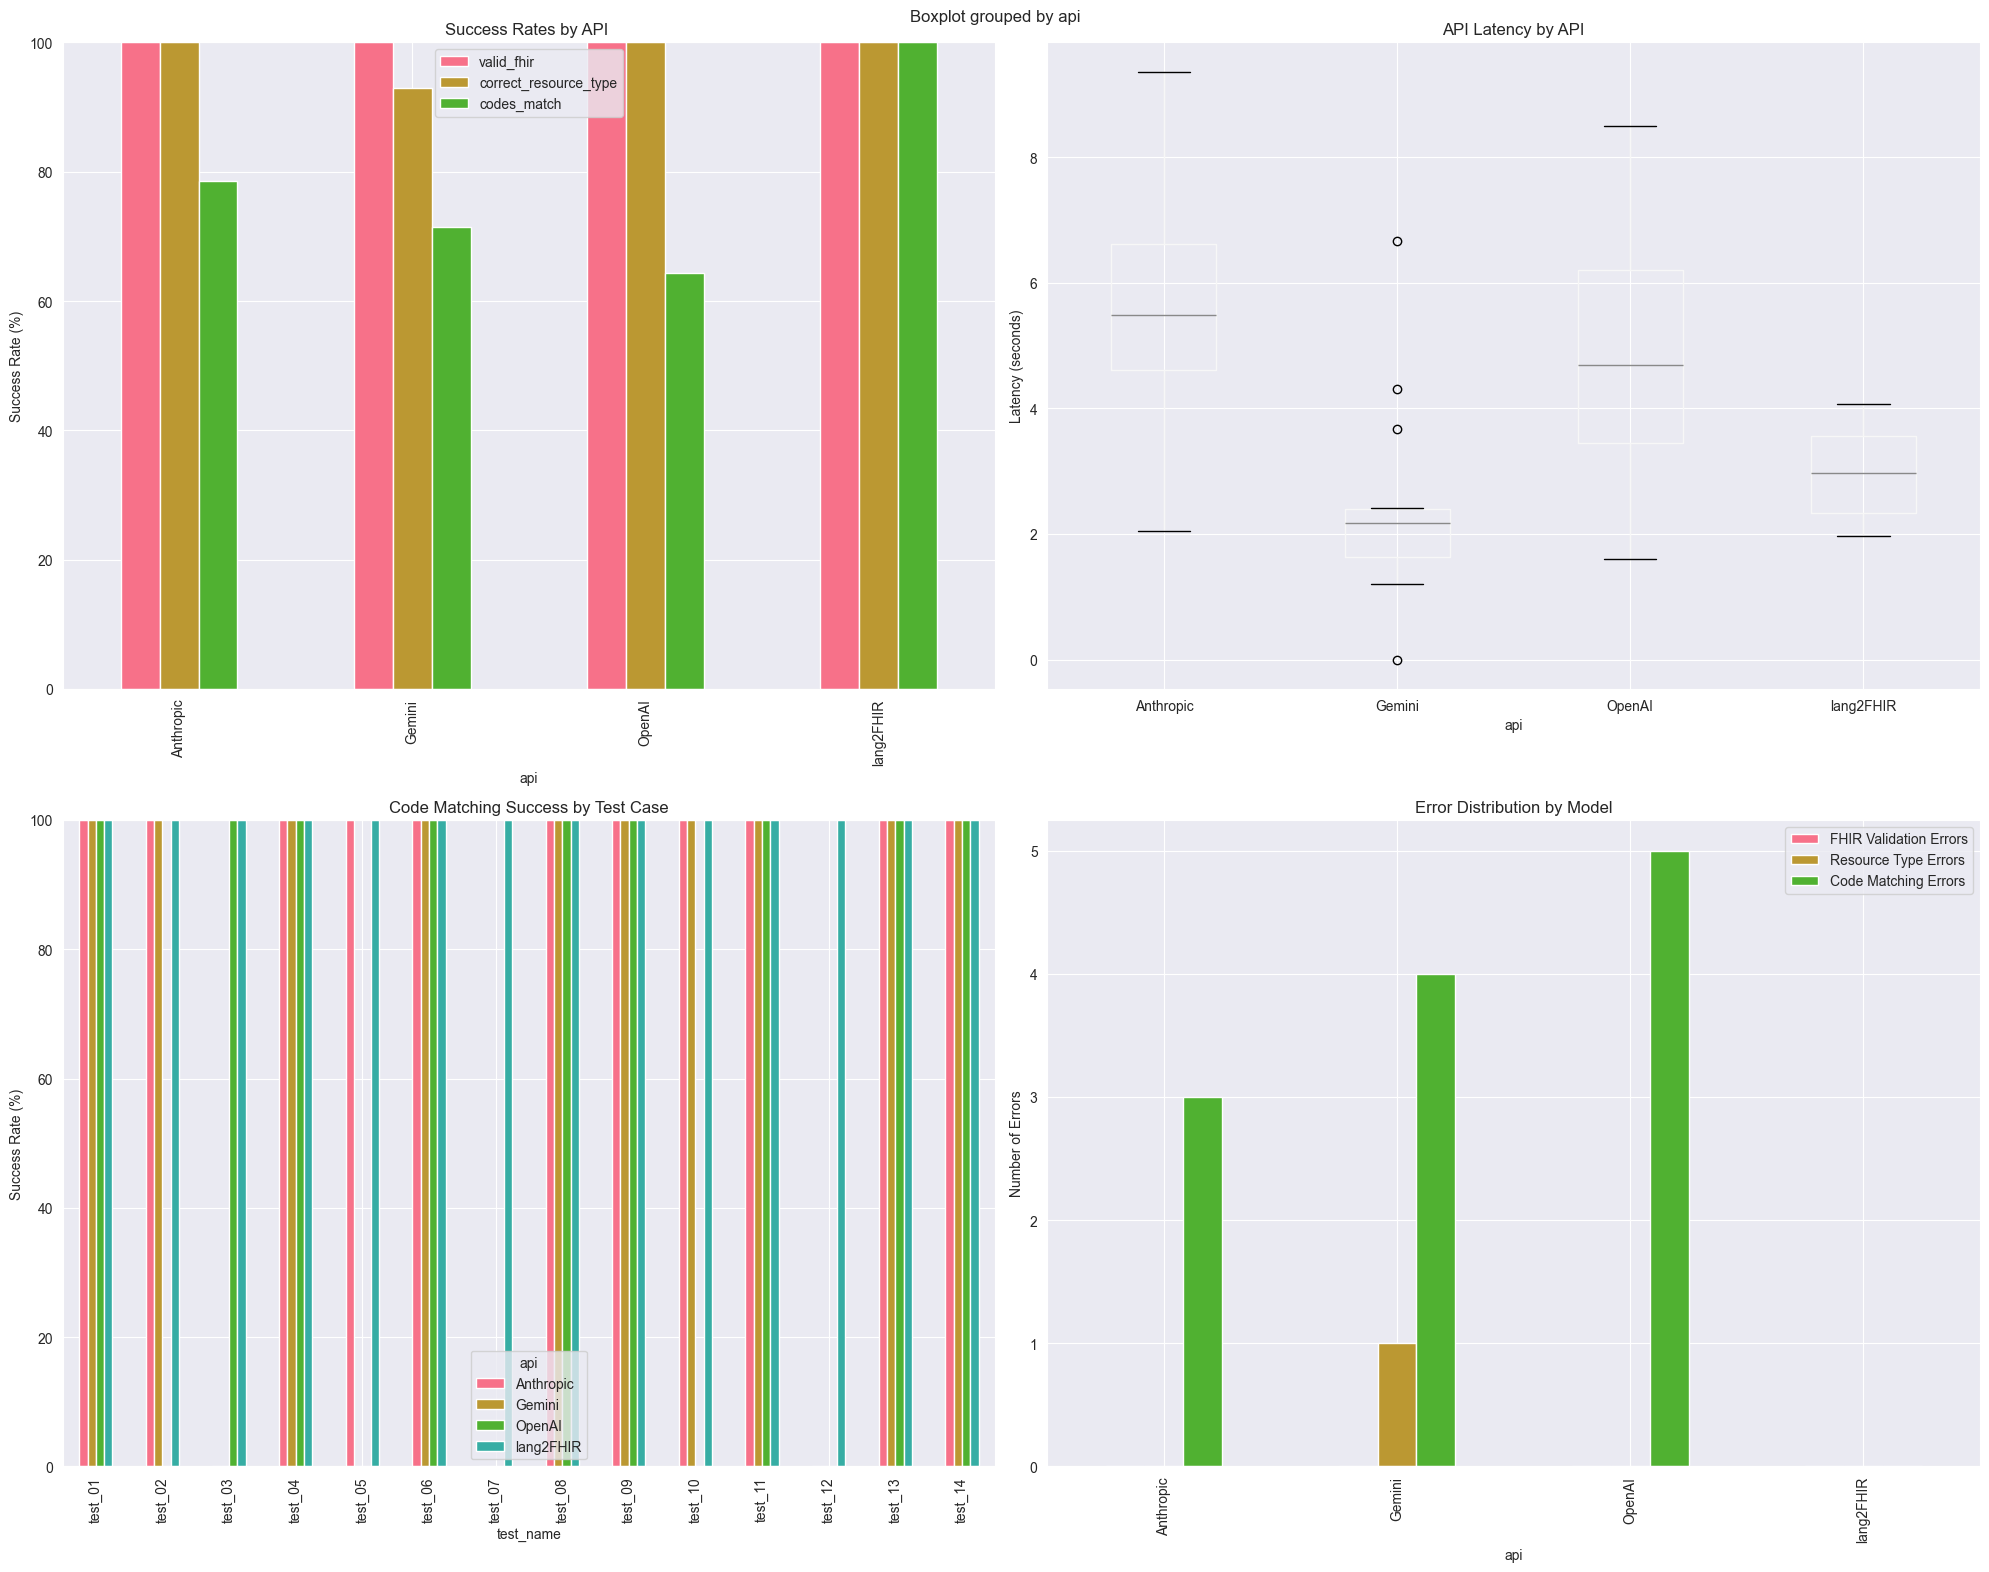

In [13]:
sns.set_style("darkgrid")  # or another style like "whitegrid", "dark", "white", "ticks"
sns.set_palette("husl")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
# 1. Success Rate by Model
success_metrics = df.groupby('api').agg({
    'valid_fhir': 'mean',
    'correct_resource_type': 'mean',
    'codes_match': 'mean'
}).round(3) * 100

success_metrics.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Success Rates by API ')
axes[0,0].set_ylabel('Success Rate (%)')
axes[0,0].set_ylim([0, 100])

# 2. Average Latency by Model
df.boxplot(column='latency', by='api', ax=axes[0,1])
axes[0,1].set_title('API Latency by API')
axes[0,1].set_ylabel('Latency (seconds)')


# 3. Success Rate by Test Case
test_success = df.pivot_table(
    index='test_name',
    columns='api',
    values='codes_match',
    aggfunc='first'
).astype(float) * 100  # Convert boolean to float and to percentage

test_success.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Code Matching Success by Test Case')
axes[1,0].set_ylabel('Success Rate (%)')
axes[1,0].set_ylim([0, 100])

# 4. Error Distribution
error_counts = df.groupby('api').apply(
    lambda x: pd.Series({
        'FHIR Validation Errors': (~x['valid_fhir']).sum(),
        'Resource Type Errors': (~x['correct_resource_type']).sum(),
        'Code Matching Errors': (~x['codes_match']).sum()
    })
).astype(int)  # Ensure counts are integers
error_counts.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Error Distribution by API')
axes[1,1].set_ylabel('Number of Errors')

plt.tight_layout()
plt.show()

In [ ]:
performance_metrics = pd.DataFrame({
    'API': df['api'].unique(),
    'Avg Latency': df.groupby('api')['latency'].mean(),
    'FHIR Valid %': df.groupby('api')['valid_fhir'].mean() * 100,
    'Correct Type %': df.groupby('api')['correct_resource_type'].mean() * 100,
    'Correct Codes %': df.groupby('api')['codes_match'].mean() * 100
}).round(2)

print("Performance Metrics by API:")
print(performance_metrics.sort_values('Correct Codes %', ascending=False))

# Cell 4: Performance by resource type
def extract_resource_type(profile):
    return profile.split('us-core-')[-1]

df['resource_type'] = df['us_core_profile'].apply(extract_resource_type)

resource_performance = df.pivot_table(
    index='resource_type',
    columns='api',
    values='codes_match',
    aggfunc='mean'
) * 100

plt.figure(figsize=(12, 6))
sns.heatmap(resource_performance, annot=True, fmt='.1f', cmap='RdYlGn')
plt.title('Success Rate (%) by Resource Type and Model')
plt.show()

# Cell 5: Latency distribution
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='api', y='latency')
plt.title('Latency Distribution by API')
plt.xticks(rotation=45)
plt.ylabel('Latency (seconds)')
plt.show()

KeyError: 'model'